## Imports

In [22]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf
from fredapi import Fred
import tensorflow as tf
from tensorflow.keras import layers, Model, backend as K
from tensorflow.keras.losses import mse
from sklearn.preprocessing import StandardScaler
from scipy.stats import wasserstein_distance, ks_2samp, entropy
from sklearn.cluster import KMeans

## Abstract

Financial markets are unpredictable, and crises such as the 2008 crash and the COVID-19 downturn have exposed flaws in traditional risk models. Conventional stress testing methods, such as historical analysis and Monte Carlo simulations, struggle to anticipate new and unprecedented crises because of their reliance on past data and simplified assumptions. These methods underestimate fat-tailed risks and fail to model the complex relationships between assets and macroeconomic factors, making them ineffective for real-world risk management.

This project leverages deep generative models-Conditional Variational Autoencoder (cVAE) and Conditional Wasserstein GAN with Gradient Penalty (WGAN-GP), to generate synthetic crisis scenarios based on macroeconomic conditions such as inflation, interest rates, and volatility. Unlike traditional methods, these models dynamically simulate extreme market movements, providing a more adaptive and data-driven approach to stress testing.

The model is applied to Warren Buffett's Q4 2019 portfolio, a well-diversified and extensively studied set of investments. The model assesses risk under conditions similar to the COVID-19 collapse, evaluating how artificial intelligence-generated scenarios compare to actual market disruptions. Key metrics such as Value at Risk (VaR), Expected Shortfall (ES), Earth Mover's Distance (EMD), and Jensen-Shannon Divergence (JSD) quantify the model's ability to capture market extremes. In addition, K-Means clustering in latent space helps to classify different levels of financial risk.

The results aim to show that deep generative models can capture extreme market conditions that traditional models fail to represent. WGAN-GP refines the synthetic scenarios by producing more realistic financial stress conditions, while cVAE enables the generation of conditional scenarios based on macroeconomic trends. In addition, K-Means clustering is applied to the latent space to classify stress scenarios into different levels of risk, identifying potential black swan financial events.

Future work includes expanding datasets, optimizing training efficiency, and validating performance across multiple financial crises. This AI-driven approach has strong potential to improve risk management for investors and financial institutions by providing a more proactive tool to anticipate financial crises.

## Data

### Parameters

Tickers: [Warren Buffett's 2019 Q4 portfolio](https://valuesider.com/guru/warren-buffett-berkshire-hathaway/portfolio/2019/4?sort=-percent_portfolio&sells_page=1&page=2).

In [23]:
tickers = [
    "AAPL",
    "BAC",
    "KO",
    "AXP",
    "WFC",
    "KHC",
    "JPM",
    "USB",
    "MCO",
    "DAL",
    "BK",
    "LUV",
    "DVA",
    "GS",
    "GM",
    "CHTR",
    "VRSN",
    "V",
    "UAL",
    "MA",
    "PNC",
    "COST",
    "AAL",
    "AMZN",
    "SIRI",
    "MTB",
    "OXY",
    "SYF",
    "AXTA",
    "GL",
    "STNE",
    "KR",
    "QSR",
    "SU",
    "LBTYA",
    "TEVA",
    "RH",
    "BIIB",
    "LBTYK",
    "LILA",
    "JNJ",
    "TRV",
    "PG",
    "MDLZ",
    "PSX",
    "LILAK",
    "VOO",
    "SPY",
    "UPS",
]

start_date = "2000-01-01"
end_date = "2025-01-01"

### Download Market Data

In [24]:
market_data = yf.download(tickers, start=start_date, end=end_date, progress=False)
market_data

Price           Close                                                 \
Ticker            AAL        AAPL        AMZN         AXP       AXTA   
Date                                                                   
2000-01-03        NaN    0.842150    4.468750   32.595165        NaN   
2000-01-04        NaN    0.771149    4.096875   31.364412        NaN   
2000-01-05        NaN    0.782433    3.487500   30.567787        NaN   
2000-01-06        NaN    0.714723    3.278125   31.190567        NaN   
2000-01-07        NaN    0.748578    3.478125   31.644674        NaN   
...               ...         ...         ...         ...        ...   
2024-12-24  17.350000  257.916443  229.050003  302.748199  34.439999   
2024-12-26  17.350000  258.735504  227.050003  303.276947  34.630001   
2024-12-27  17.350000  255.309296  223.750000  300.343842  34.369999   
2024-12-30  17.620001  251.923019  221.300003  296.632568  34.009998   
2024-12-31  17.430000  250.144974  219.389999  296.093842  34.220001   

Price                                                                 ...  \
Ticker            BAC        BIIB         BK        CHTR        COST  ...   
Date                                                                  ...   
2000-01-03  12.714029   31.083332  21.912376         NaN   29.851648  ...   
2000-01-04  11.959391   28.979168  21.283136         NaN   28.216513  ...   
2000-01-05  12.090633   31.000000  20.801960         NaN   28.698656  ...   
2000-01-06  13.124159   32.375000  21.320147         NaN   29.275167  ...   
2000-01-07  12.779649   36.104168  22.430571         NaN   31.214252  ...   
...               ...         ...        ...         ...         ...  ...   
2024-12-24  44.380001  149.020004  77.622406  352.190002  957.761780  ...   
2024-12-26  44.549999  149.899994  77.920761  351.779999  955.084717  ...   
2024-12-27  44.340000  151.309998  77.145035  348.649994  938.662842  ...   
2024-12-30  43.910000  150.190002  76.687553  343.179993  921.192200  ...   
2024-12-31  43.950001  152.919998  76.409088  342.769989  915.258728  ...   

Price          Volume                                                 \
Ticker            SYF      TEVA     TRV        UAL      UPS      USB   
Date                                                                   
2000-01-03        NaN   3145600  336400        NaN  1273200  2354200   
2000-01-04        NaN   4314400  494400        NaN  1385800  3687700   
2000-01-05        NaN   3379200  736000        NaN  1401700  2704200   
2000-01-06        NaN   2148000  660400        NaN  1959100  4185300   
2000-01-07        NaN  10913600  594700        NaN   996000  4486700   
...               ...       ...     ...        ...      ...      ...   
2024-12-24   809500.0   3026000  329200  1968600.0  1579200  2393800   
2024-12-26  1622900.0   7485000  434100  2226900.0  3011100  3448200   
2024-12-27  1321600.0   6927200  631700  3156900.0  2904000  4956900   
2024-12-30  2093500.0   9601700  734300  3886400.0  2953900  4868400   
2024-12-31  1357900.0   6321600  795100  2816800.0  3400800  4521400   

Price                                                
Ticker              V        VOO     VRSN       WFC  
Date                                                 
2000-01-03        NaN        NaN  2270100   9037000  
2000-01-04        NaN        NaN  3002200  15237200  
2000-01-05        NaN        NaN  6886600   8228200  
2000-01-06        NaN        NaN  4003200   8326800  
2000-01-07        NaN        NaN  3803200   7711200  
...               ...        ...      ...       ...  
2024-12-24  2684100.0  3439300.0   219200   4442700  
2024-12-26  2856000.0  4492000.0   368200   6964300  
2024-12-27  3489200.0  7077100.0   569600   7219500  
2024-12-30  3478500.0  6505100.0   905800   8443800  
2024-12-31  3963800.0  6040800.0   985200   7031500  

[6289 rows x 245 columns]

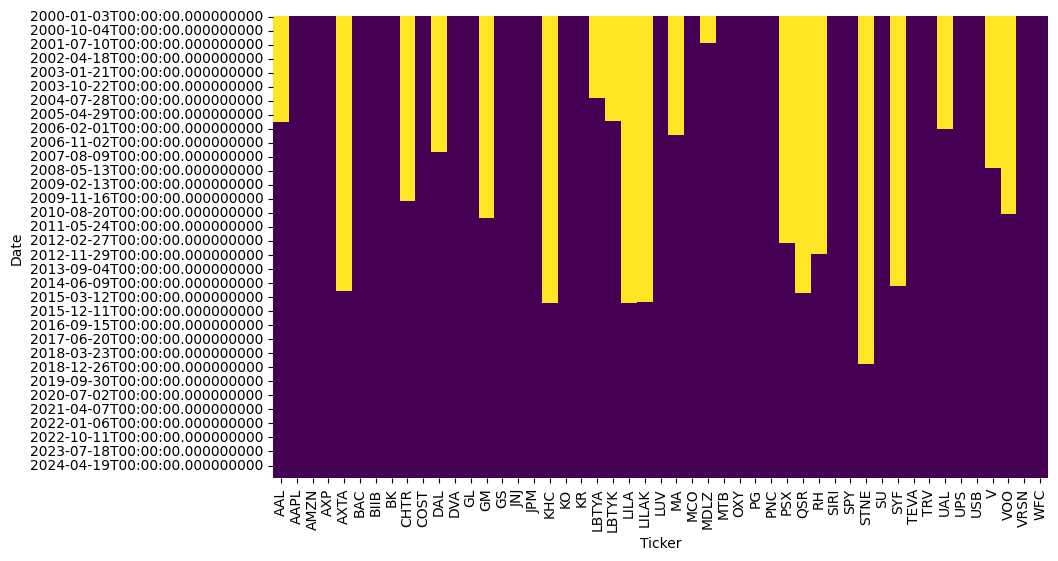

In [25]:
plt.figure(figsize=(10,6))
sns.heatmap(market_data["Close"].isnull(), cmap="viridis", cbar=False)
plt.show()

In [26]:
market_data = market_data["Close"].dropna()

returns = np.log(market_data / market_data.shift(1)).dropna()

returns_scaler = StandardScaler()
returns_scaled = returns.copy()
returns_scaled.iloc[:] = returns_scaler.fit_transform(returns_scaled)

In [27]:
returns.head()

Ticker,AAL,AAPL,AMZN,AXP,AXTA,BAC,BIIB,BK,CHTR,COST,...,SYF,TEVA,TRV,UAL,UPS,USB,V,VOO,VRSN,WFC
Date,,,,,,,,,,,,,,,,,,,,,
2018-10-26,0.002777,-0.016052,-0.081423,-0.022945,-0.024843,-0.007550,0.005680,-0.014844,-0.064960,-0.036937,...,-0.029927,-0.030002,0.000412,-0.011396,-0.023555,-0.007046,-0.019982,-0.017850,0.020619,-0.011832
2018-10-29,0.004304,-0.018949,-0.065353,-0.000593,-0.010780,0.008302,0.002628,0.012753,0.019603,0.019201,...,0.001072,-0.006110,0.008456,0.004245,-0.001711,0.012687,-0.025068,-0.005182,-0.024455,0.018941
2018-10-30,0.061274,0.004982,-0.005513,0.008757,0.025109,0.006368,0.017522,0.024815,0.049826,0.024427,...,0.025728,0.009151,0.028609,0.010068,0.018285,0.014632,-0.011757,0.015183,0.024383,0.008769
2018-10-31,0.012045,0.025733,0.043217,0.006347,0.003247,0.026531,-0.006584,0.008700,0.013038,0.003111,...,0.004859,0.011072,-0.005897,-0.003968,-0.004962,-0.000956,0.037623,0.010424,0.027598,0.010197
2018-11-01,0.036113,0.015236,0.041384,0.012671,0.031115,0.011210,0.035704,0.004006,0.013055,0.004234,...,0.019205,0.140762,0.000559,0.029158,0.009156,-0.002682,0.021387,0.010317,-0.012282,0.006180


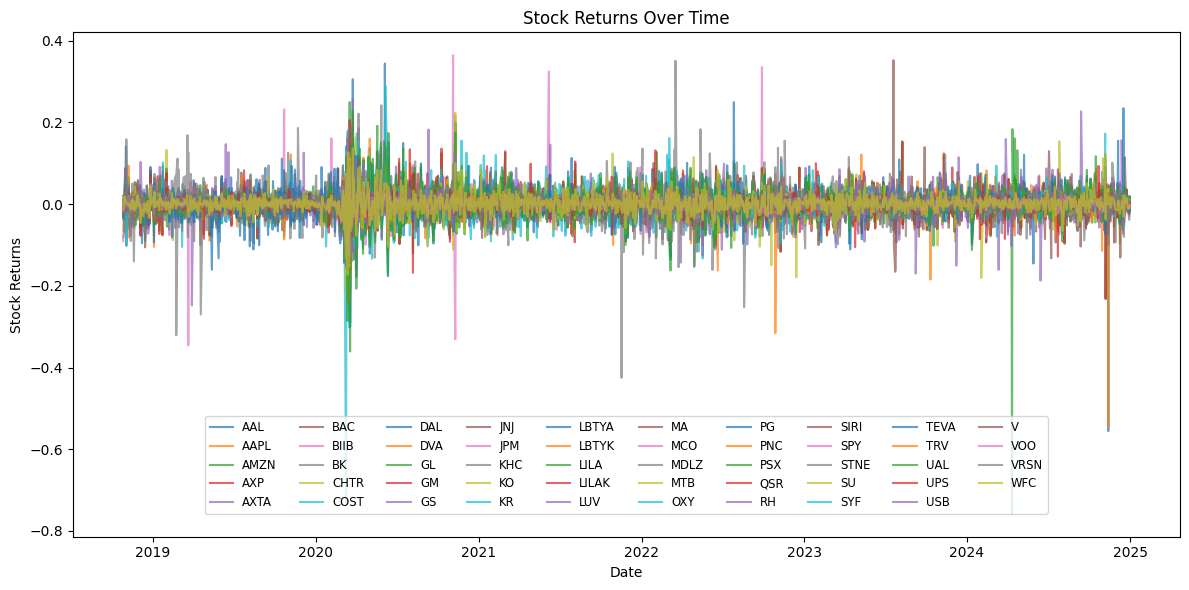

In [28]:
fig, ax = plt.subplots(figsize=(12, 6))

for ticker in returns.columns:
    ax.plot(returns.index, returns[ticker], label=ticker, alpha=0.7)

ax.set_xlabel('Date')
ax.set_ylabel('Stock Returns')
plt.title('Stock Returns Over Time')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 0.25), fontsize='small', ncol=10)
fig.tight_layout()
plt.show()

### Download and Prepare Macroeconomic Indicators

In [29]:
with open("key_fred.txt", "r") as file:
    key_fred = file.read().strip()

fred = Fred(api_key=key_fred)

inflation = fred.get_series("CPIAUCSL")
fed_funds = fred.get_series("FEDFUNDS")
unemployment = fred.get_series("UNRATE")
short_term = fred.get_series("DGS3MO")
long_term = fred.get_series("DGS10")

In [30]:
macro_df = pd.concat(
    [inflation, fed_funds, unemployment, short_term, long_term], axis=1
)
macro_df.ffill(inplace=True)
macro_df = macro_df.loc[start_date:end_date]
macro_df.columns = ["inflation", "fed_funds", "unemployment", "short_term", "long_term"]

vix_df = yf.download("^VIX", start=start_date, end=end_date, progress=False)

vix_column = "Adj Close" if "Adj Close" in vix_df.columns else "Close"

if isinstance(vix_df.columns, pd.MultiIndex):
    vix_data = vix_df[("Close", "^VIX")].rename("vix")
else:
    vix_data = vix_df["Close"].rename("vix")

macro_df = pd.concat([macro_df, vix_data], axis=1)
macro_df = macro_df.reindex(returns.index).ffill()

macro_scaler = StandardScaler()
macro_scaled = macro_scaler.fit_transform(macro_df)

In [31]:
macro_df.head()

,inflation,fed_funds,unemployment,short_term,long_term,vix
Date,,,,,,
2018-10-26,252.772,2.19,3.8,2.33,3.08,24.160000
2018-10-29,252.772,2.19,3.8,2.34,3.08,24.700001
2018-10-30,252.772,2.19,3.8,2.33,3.12,23.350000
2018-10-31,252.772,2.19,3.8,2.34,3.15,21.230000
2018-11-01,252.594,2.20,3.8,2.32,3.14,19.340000


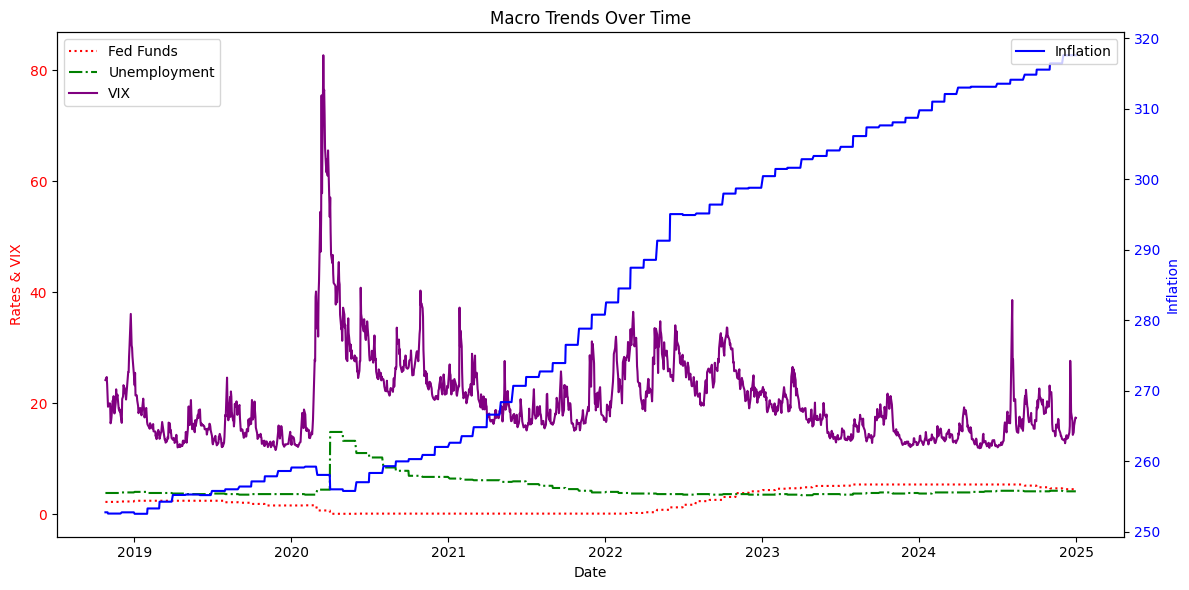

In [32]:
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.set_xlabel('Date')
ax1.set_ylabel('Rates & VIX', color='red')
ax1.plot(macro_df.index, macro_df['fed_funds'], color='red', linestyle='dotted', label='Fed Funds')
ax1.plot(macro_df.index, macro_df['unemployment'], color='green', linestyle='dashdot', label='Unemployment')
ax1.plot(macro_df.index, macro_df['vix'], color='purple', linestyle='solid', label='VIX')
ax1.tick_params(axis='y', labelcolor='red')

ax2 = ax1.twinx()
ax2.set_ylabel('Inflation', color='blue')
ax2.plot(macro_df.index, macro_df['inflation'], color='blue', label='Inflation')
ax2.tick_params(axis='y', labelcolor='blue')

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.title('Macro Trends Over Time')
fig.tight_layout()
plt.show()

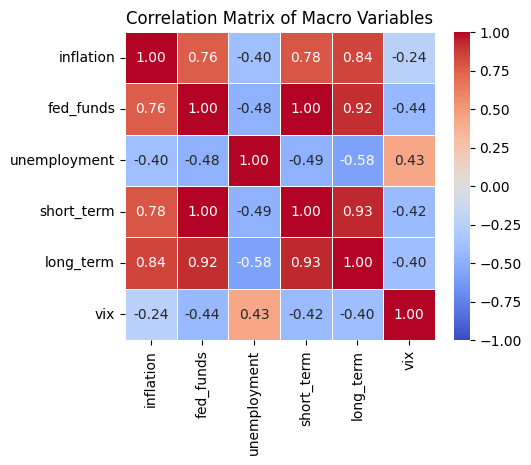

In [33]:
corr_matrix = macro_df.corr()

plt.figure(figsize=(5, 4))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5, vmin=-1, vmax=1)
plt.title("Correlation Matrix of Macro Variables")
plt.show()

## Define custom layers: Sampling, Reconstruction Loss, KL Divergence

In [7]:
class SamplingLayer(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


class ReconstructionLossLayer(layers.Layer):
    def call(self, inputs):
        x, x_pred = inputs
        loss = K.mean(mse(x, x_pred))
        self.add_loss(loss)
        return x_pred


class KLDivergenceLayer(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        kl_loss = -0.5 * tf.reduce_sum(
            1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1
        )
        self.add_loss(tf.reduce_mean(kl_loss))
        return z_mean

## Conditional VAE: Unconditioned Encoder, Conditioned Decoder with Dropout

In [8]:
def build_conditional_vae(input_dim, macro_dim, intermediate_dim=256, latent_dim=2):
    x_input = layers.Input(shape=(input_dim,), name="returns_input")
    h = layers.Dense(intermediate_dim, activation="relu")(x_input)
    z_mean = layers.Dense(latent_dim, name="z_mean")(h)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(h)

    z_mean = KLDivergenceLayer()([z_mean, z_log_var])

    z = SamplingLayer(name="z")([z_mean, z_log_var])
    encoder = Model(x_input, [z_mean, z_log_var, z], name="encoder")

    # Decoder
    cond_input = layers.Input(shape=(macro_dim,), name="macro_input")
    decoder_input = layers.Concatenate(name="concat_decoder")([z, cond_input])
    d = layers.Dense(intermediate_dim, activation="relu")(decoder_input)
    d = layers.Dense(intermediate_dim // 2, activation="relu")(d)
    outputs = layers.Dense(input_dim, activation="linear")(d)
    decoder = Model([z, cond_input], outputs, name="decoder")

    # Conditional VAE Model
    vae_output = decoder([encoder(x_input)[2], cond_input])
    x_pred = ReconstructionLossLayer()([x_input, vae_output])
    cvae = Model([x_input, cond_input], x_pred, name="cvae")

    # Compile the model
    cvae.compile(optimizer="adam")

    return encoder, decoder, cvae

## Conditional Generator and Critic (WGAN-GP) with Increased Depth and Dropout

In [9]:
def build_conditional_generator(noise_dim, macro_dim, latent_dim):
    noise_input = layers.Input(shape=(noise_dim,), name="noise_input")
    macro_input = layers.Input(shape=(macro_dim,), name="macro_input_gen")
    x = layers.Concatenate(name="concat_gen")([noise_input, macro_input])
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dense(64, activation="relu")(x)
    output_latent = layers.Dense(latent_dim, name="latent_generated")(x)
    model = Model(
        [noise_input, macro_input], output_latent, name="conditional_generator"
    )
    return model


def build_conditional_critic(latent_dim, macro_dim):
    latent_input = layers.Input(shape=(latent_dim,), name="latent_input")
    macro_input = layers.Input(shape=(macro_dim,), name="macro_input_critic")
    x = layers.Concatenate(name="concat_critic")([latent_input, macro_input])
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dense(64, activation="relu")(x)
    output_score = layers.Dense(1, name="critic_score")(x)
    model = Model([latent_input, macro_input], output_score, name="conditional_critic")
    return model


def gradient_penalty_cond(critic, real_latent, fake_latent, macro, batch_size):
    alpha = tf.random.uniform([batch_size, 1], 0.0, 1.0)
    interpolated_latent = alpha * real_latent + (1 - alpha) * fake_latent
    with tf.GradientTape() as gp_tape:
        gp_tape.watch(interpolated_latent)
        interpolated_output = critic([interpolated_latent, macro])
    grads = gp_tape.gradient(interpolated_output, [interpolated_latent])[0]
    norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=1) + 1e-12)
    gp = tf.reduce_mean((norm - 1.0) ** 2)
    return gp


def train_conditional_wgan_gp(
    generator,
    critic,
    real_latent,
    real_macro,
    noise_dim,
    batch_size=32,
    epochs=1000,
    critic_iterations=5,
    lambda_gp=10.0,
):
    gen_optimizer = tf.keras.optimizers.Adam(
        learning_rate=0.0001, beta_1=0.5, beta_2=0.9
    )
    critic_optimizer = tf.keras.optimizers.Adam(
        learning_rate=0.0001, beta_1=0.5, beta_2=0.9
    )

    dataset = tf.data.Dataset.from_tensor_slices(
        (real_latent.astype("float32"), real_macro.astype("float32"))
    )
    dataset = dataset.shuffle(1024).batch(batch_size)

    for epoch in range(1, epochs+1):
        for latent_batch, macro_batch in dataset:
            current_batch_size = tf.shape(macro_batch)[0]
            for _ in range(critic_iterations):
                noise = tf.random.normal([current_batch_size, noise_dim])
                with tf.GradientTape() as tape:
                    fake_latent = generator([noise, macro_batch])
                    critic_real = critic([latent_batch, macro_batch])
                    critic_fake = critic([fake_latent, macro_batch])
                    gp = gradient_penalty_cond(
                        critic,
                        latent_batch,
                        fake_latent,
                        macro_batch,
                        current_batch_size,
                    )
                    critic_loss = (
                        tf.reduce_mean(critic_fake)
                        - tf.reduce_mean(critic_real)
                        + lambda_gp * gp
                    )
                grads = tape.gradient(critic_loss, critic.trainable_variables)
                critic_optimizer.apply_gradients(zip(grads, critic.trainable_variables))

            noise = tf.random.normal([current_batch_size, noise_dim])
            with tf.GradientTape() as tape:
                fake_latent = generator([noise, macro_batch])
                gen_loss = -tf.reduce_mean(critic([fake_latent, macro_batch]))
            grads = tape.gradient(gen_loss, generator.trainable_variables)
            gen_optimizer.apply_gradients(zip(grads, generator.trainable_variables))

        if epoch % 100 == 0 or epoch == 1:
            print(f"Epoch {epoch}: Critic Loss = {critic_loss.numpy():.4f}, Gen Loss = {gen_loss.numpy():.4f}")

    return generator

## Metrics and Validation Functions

In [10]:
def compute_portfolio_returns(returns_array, weights):
    return returns_array.dot(weights)


def calculate_var_es(portfolio_returns, alpha=5):
    var_threshold = np.percentile(portfolio_returns, alpha)
    es = portfolio_returns[portfolio_returns <= var_threshold].mean()
    return var_threshold, es


def select_extreme_scenarios(synthetic_returns, portfolio_weights, alpha=5):
    portfolio_returns = compute_portfolio_returns(synthetic_returns, portfolio_weights)
    var_threshold, es = calculate_var_es(portfolio_returns, alpha)
    extreme_indices = np.where(portfolio_returns <= var_threshold)[0]
    extreme_scenarios = synthetic_returns[extreme_indices]
    return extreme_scenarios, var_threshold, es, portfolio_returns


def jensen_shannon_divergence(p, q):
    m = 0.5 * (p + q)
    return 0.5 * (entropy(p, m) + entropy(q, m))

## Clustering Function for Latent Space Scenarios

In [11]:
def cluster_extreme_latent(z_codes, n_clusters=3):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(z_codes)
    global_center = np.mean(z_codes, axis=0)
    distances = np.linalg.norm(kmeans.cluster_centers_ - global_center, axis=1)
    extreme_cluster = np.argmax(distances)
    extreme_indices = np.where(clusters == extreme_cluster)[0]
    return extreme_indices, clusters, kmeans.cluster_centers_

## Training and Stress Testing

In [ ]:
n_samples = min(returns_scaled.shape[0], macro_scaled.shape[0])
returns_scaled = returns_scaled[:n_samples]
macro_scaled = macro_scaled[:n_samples]

### VAE

In [13]:
input_dim = returns_scaled.shape[1]
macro_dim = macro_scaled.shape[1]
latent_dim = 2
print("Training Conditional VAE...")
encoder, decoder, cvae = build_conditional_vae(
    input_dim, macro_dim, intermediate_dim=256, latent_dim=latent_dim
)
cvae.fit([returns_scaled, macro_scaled], epochs=50, batch_size=32, verbose=1)
z_mean_train, _, _ = encoder.predict(returns_scaled)

Training Conditional VAE...
Epoch 1/50


2025-03-02 00:38:49.218681: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2025-03-02 00:38:49.218699: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:137] retrieving CUDA diagnostic information for host: ggrrcc-MS-7E12
2025-03-02 00:38:49.218703: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:144] hostname: ggrrcc-MS-7E12
2025-03-02 00:38:49.218747: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:168] libcuda reported version is: 535.183.1
2025-03-02 00:38:49.218758: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:172] kernel reported version is: 535.183.1
2025-03-02 00:38:49.218761: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:259] kernel version seems to match DSO: 535.183.1



 1/49 ━━━━━━━━━━━━━━━━━━━━ 30s 637ms/step - loss: 0.9310


49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 949us/step - loss: 1.1535 


Epoch 2/50



 1/49 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.0200


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 855us/step - loss: 1.0219


Epoch 3/50



 1/49 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.4900


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step - loss: 1.0484


Epoch 4/50



 1/49 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.8026


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step - loss: 0.9105


Epoch 5/50



 1/49 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.5257


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step - loss: 0.9854


Epoch 6/50



 1/49 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.8159


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step - loss: 0.8976


Epoch 7/50



 1/49 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.8215


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step - loss: 0.9793


Epoch 8/50



 1/49 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.8739


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step - loss: 0.9997


Epoch 9/50



 1/49 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.3952


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step - loss: 1.0441


Epoch 10/50



 1/49 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.9134


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step - loss: 1.1021


Epoch 11/50



 1/49 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.8976


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step - loss: 1.0378


Epoch 12/50



 1/49 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.8507


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step - loss: 0.8873


Epoch 13/50



 1/49 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.8963


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step - loss: 0.9468


Epoch 14/50



 1/49 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.8048


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step - loss: 1.1968


Epoch 15/50



 1/49 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.9119


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step - loss: 0.8983


Epoch 16/50



 1/49 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7982


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step - loss: 0.8673


Epoch 17/50



 1/49 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7565


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step - loss: 0.9223


Epoch 18/50



 1/49 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7435


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step - loss: 0.9059


Epoch 19/50



 1/49 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7962


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step - loss: 0.8567


Epoch 20/50



 1/49 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.0761


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step - loss: 0.8623


Epoch 21/50



 1/49 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.5951


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step - loss: 0.9344


Epoch 22/50



 1/49 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7363


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 749us/step - loss: 0.8970


Epoch 23/50



 1/49 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7988


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step - loss: 0.8464


Epoch 24/50



 1/49 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4360


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step - loss: 0.8392


Epoch 25/50



 1/49 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.0965


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step - loss: 0.8887


Epoch 26/50



 1/49 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7502


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step - loss: 0.8413


Epoch 27/50



 1/49 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.7091


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step - loss: 1.1200


Epoch 28/50



 1/49 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6001


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step - loss: 0.9132


Epoch 29/50



 1/49 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.9642


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step - loss: 0.9561


Epoch 30/50



 1/49 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7835


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step - loss: 0.8661


Epoch 31/50



 1/49 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6516


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step - loss: 0.8715


Epoch 32/50



 1/49 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.0612


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step - loss: 0.9188


Epoch 33/50



 1/49 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.0250


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step - loss: 0.8979


Epoch 34/50



 1/49 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7217


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step - loss: 0.9054


Epoch 35/50



 1/49 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.2946


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step - loss: 0.9143


Epoch 36/50



 1/49 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6151


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step - loss: 0.8726


Epoch 37/50



 1/49 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.9957


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step - loss: 0.9179


Epoch 38/50



 1/49 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6970


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step - loss: 0.8274


Epoch 39/50



 1/49 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.8726


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step - loss: 0.8953


Epoch 40/50



 1/49 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.4165


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step - loss: 0.9626


Epoch 41/50



 1/49 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.5514


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step - loss: 0.8525


Epoch 42/50



 1/49 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.1744


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step - loss: 0.8882


Epoch 43/50



 1/49 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6807


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step - loss: 0.8371


Epoch 44/50



 1/49 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.1471


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step - loss: 0.8966


Epoch 45/50



 1/49 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.8653


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step - loss: 0.8870


Epoch 46/50



 1/49 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7744


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step - loss: 0.9269


Epoch 47/50



 1/49 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7549


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step - loss: 0.9005


Epoch 48/50



 1/49 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.5999


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step - loss: 0.8626


Epoch 49/50



 1/49 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6914


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step - loss: 0.8500


Epoch 50/50



 1/49 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.8721


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step - loss: 0.8983



 1/49 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step


### WGAN-GP

In [14]:
noise_dim = 10
print("Training Conditional WGAN-GP...")
generator = build_conditional_generator(noise_dim, macro_dim, latent_dim)
critic = build_conditional_critic(latent_dim, macro_dim)
generator = train_conditional_wgan_gp(
    generator,
    critic,
    z_mean_train,
    macro_scaled,
    noise_dim,
    batch_size=32,
    epochs=1000,
    critic_iterations=5,
    lambda_gp=10.0,
)

Training Conditional WGAN-GP...


2025-03-02 00:38:59.626840: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1: Critic Loss = 4.0072, Gen Loss = -2.0853


2025-03-02 00:39:07.138598: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2025-03-02 00:39:22.551340: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2025-03-02 00:39:53.708860: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2025-03-02 00:40:53.436617: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2025-03-02 00:42:51.387355: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2025-03-02 00:46:45.995963: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 100: Critic Loss = -0.0317, Gen Loss = -0.0831


2025-03-02 00:54:56.718893: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 200: Critic Loss = 0.1884, Gen Loss = 0.4451


2025-03-02 01:10:27.569908: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 300: Critic Loss = -0.2063, Gen Loss = -2.1968


Epoch 400: Critic Loss = 0.1017, Gen Loss = -2.2640


Epoch 500: Critic Loss = 0.1469, Gen Loss = 0.0087


2025-03-02 01:42:07.945253: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 600: Critic Loss = -0.2373, Gen Loss = 1.1263


Epoch 700: Critic Loss = 0.2557, Gen Loss = 0.6589


Epoch 800: Critic Loss = -0.1758, Gen Loss = 0.2383


Epoch 900: Critic Loss = -0.3631, Gen Loss = -2.6580


Epoch 1000: Critic Loss = -0.0037, Gen Loss = -4.1766


### Save Models

In [15]:
encoder.save("models/encoder_model.keras")
decoder.save("models/decoder_model.keras")
cvae.save("models/cvae_model.keras")
generator.save("models/generator_model.keras")
critic.save("models/critic_model.keras")

### Generate New Synthetic Scenarios

In [16]:
num_samples_to_generate = 1000
idx = np.random.choice(macro_scaled.shape[0], num_samples_to_generate, replace=True)
macro_conditions_sample = macro_scaled[idx]
macro_conditions_sample = tf.convert_to_tensor(
    macro_conditions_sample, dtype=tf.float32
)
noise = tf.random.normal([num_samples_to_generate, noise_dim])
generated_latent = generator([noise, macro_conditions_sample]).numpy()

synthetic_returns_scaled = decoder.predict([generated_latent, macro_conditions_sample])
synthetic_returns = returns_scaler.inverse_transform(synthetic_returns_scaled)


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step


#### Stress Testing

In [17]:
portfolio_weights = np.array([1 / len(tickers)] * len(tickers))
extreme_scenarios, var_threshold, es, synthetic_portfolio_returns = (
    select_extreme_scenarios(synthetic_returns, portfolio_weights, alpha=5)
)
historical_portfolio_returns = compute_portfolio_returns(
    returns.values, portfolio_weights
)
emd_distance = wasserstein_distance(
    historical_portfolio_returns, synthetic_portfolio_returns
)

hist_real, bin_edges = np.histogram(returns.values[:, 0], bins=50, density=True)
hist_syn, _ = np.histogram(synthetic_returns[:, 0], bins=bin_edges, density=True)
js_div = jensen_shannon_divergence(hist_real + 1e-8, hist_syn + 1e-8)
ks_stat, ks_pvalue = ks_2samp(returns.values[:, 0], synthetic_returns[:, 0])


def autocorr(x, lag=1):
    return np.corrcoef(x[:-lag], x[lag:])[0, 1]


autocorr_real = np.mean(
    [autocorr(returns.values[:, i]) for i in range(returns.values.shape[1])]
)
autocorr_syn = np.mean(
    [autocorr(synthetic_returns[:, i]) for i in range(synthetic_returns.shape[1])]
)

extreme_indices_cluster, clusters, cluster_centers = cluster_extreme_latent(
    generated_latent, n_clusters=3
)

#### Stress Testing Results

In [18]:
print("--- Stress Testing Results ---")
print(f"VaR (5th percentile): {var_threshold:.4f}")
print(f"Expected Shortfall: {es:.4f}")
print(f"Number of extreme scenarios (VaR): {extreme_scenarios.shape[0]}")
print(f"Earth Mover's Distance: {emd_distance:.4f}")
print(f"Jensen-Shannon Divergence (asset 1): {js_div:.4f}")
print(f"KS-test statistic (asset 1): {ks_stat:.4f}, p-value: {ks_pvalue:.4f}")
print(f"Mean autocorrelation lag-1: real = {autocorr_real:.4f}, synthetic = {autocorr_syn:.4f}")
print(f"Number of scenarios in extreme cluster (K-Means): {len(extreme_indices_cluster)}")

--- Stress Testing Results ---
VaR (5th percentile): -0.0094
Expected Shortfall: -0.0218
Number of extreme scenarios (VaR): 50
Earth Mover's Distance: 0.0070
Jensen-Shannon Divergence (asset 1): 0.2148
KS-test statistic (asset 1): 0.3698, p-value: 0.0000
Mean autocorrelation lag-1: real = -0.0546, synthetic = -0.0198
Number of scenarios in extreme cluster (K-Means): 102


## Visualization

### Histogram of Synthetic Portfolio Returns

- This graph helps compare the distribution of real and synthetic portfolio returns
- It highlights the Value at Risk (VaR) threshold, showing the probability of extreme losses

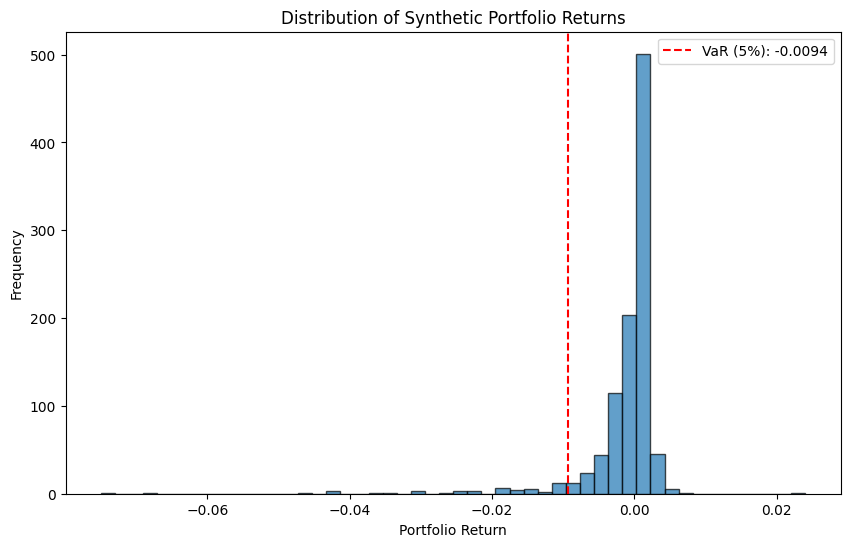

In [19]:
plt.figure(figsize=(10, 6))
plt.hist(synthetic_portfolio_returns, bins=50, alpha=0.7, edgecolor="black")
plt.axvline(
    var_threshold, color="r", linestyle="--", label=f"VaR (5%): {var_threshold:.4f}"
)
plt.xlabel("Portfolio Return")
plt.ylabel("Frequency")
plt.title("Distribution of Synthetic Portfolio Returns")
plt.legend()
plt.show()

### Heatmap of Extreme Scenarios (VaR)

- This visualization identifies which assets are most impacted in extreme market conditions
- It helps understand how different stocks contribute to high-risk scenarios

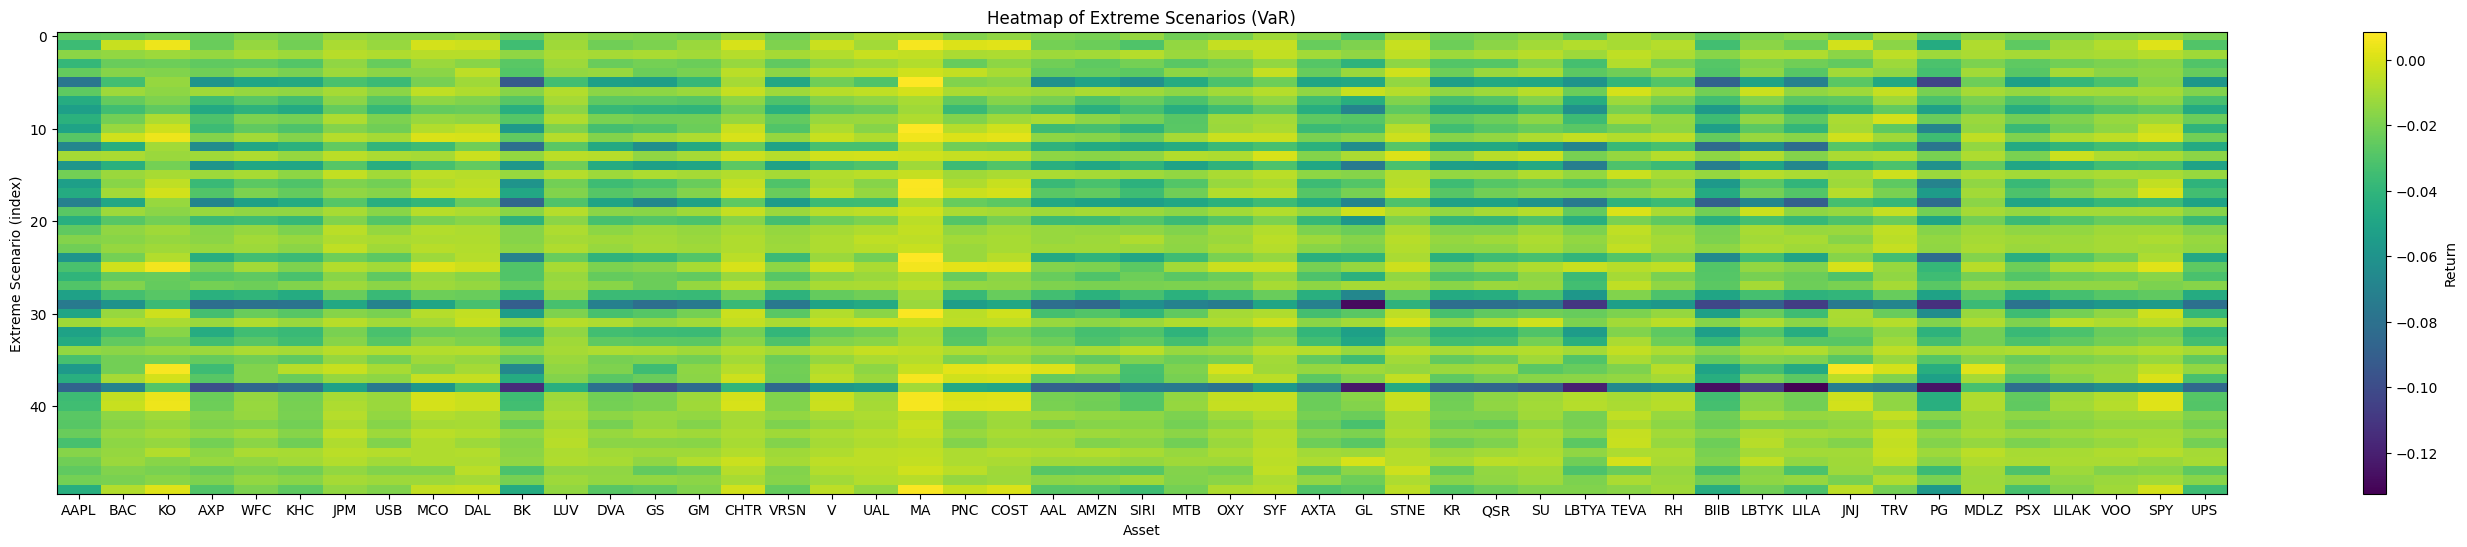

In [20]:
plt.figure(figsize=(35, 6))
plt.imshow(extreme_scenarios, aspect="auto", cmap="viridis")
plt.colorbar(label="Return")
plt.xticks(ticks=np.arange(len(tickers)), labels=tickers)
plt.xlabel("Asset")
plt.ylabel("Extreme Scenario (index)")
plt.title("Heatmap of Extreme Scenarios (VaR)")
plt.show()

### Scatter Plot of Latent Space with Clusters

- This plot represents different generated market scenarios in a latent space
- It clusters normal, moderate, and extreme financial conditions, helping to identify outliers associated with potential market crashes

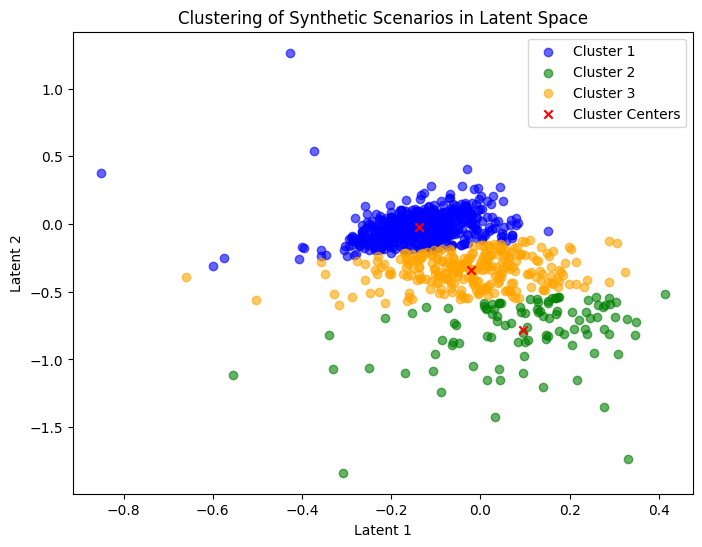

In [21]:
plt.figure(figsize=(8, 6))

colors = ["blue", "green", "orange"]
cluster_colors = [colors[c] for c in clusters]
for i, color in enumerate(colors):
    plt.scatter(
        generated_latent[clusters == i, 0],
        generated_latent[clusters == i, 1],
        c=color,
        alpha=0.6,
        label=f"Cluster {i+1}",
    )
plt.scatter(
    cluster_centers[:, 0],
    cluster_centers[:, 1],
    c="red",
    marker="x",
    label="Cluster Centers",
)
plt.xlabel("Latent 1")
plt.ylabel("Latent 2")
plt.title("Clustering of Synthetic Scenarios in Latent Space")
plt.legend()
plt.show()